In [9]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
import web

In [51]:
train_data, train_label, validation_data, validation_label, test_data, test_label = web.data_preparation()
trained_model=web.main()
predicted_indexes=trained_model.predict(test_data)
predicted_indexes=predicted_indexes.squeeze()
import pandas as pd
predicted_indexes_df = pd.DataFrame({'predicted_index':predicted_indexes,'actual_index':test_label})

Training data shape = (28338, 1)
Validation data shape = (28338, 1)
Test data shape = (28338, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                20        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 35
Trainable params: 33
Non-trainable params: 2
_________________________________________________________________
Train on 28338 samples, validate on 28338 samples
Epoch 1/100
28338/28338 [==============================] - 4s 139us/step - loss: 141684.6740 - mean_absolute_error: 141684.6740 - v

In [111]:
predicted_indexes_df.groupby('predicted_index').count()

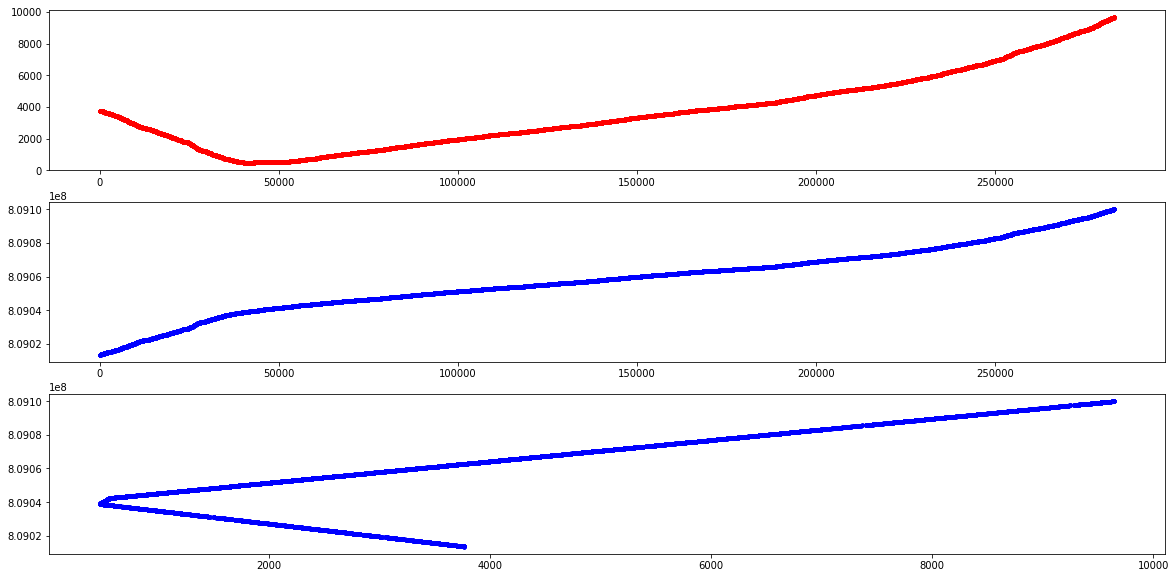

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(311)
ax.plot(predicted_indexes_df.actual_index, predicted_indexes_df.predicted_index,'r.');

ax = fig.add_subplot(312)
ax.plot(train_label,train_data,'b.')

ax = fig.add_subplot(313)
ax.plot(predicted_indexes_df.predicted_index,train_data,'b.')

In [2]:
train_data, train_label, validation_data, validation_label, test_data, test_label = web.data_preparation_moe()
trained_model=web.main1()
predicted_indexes_moe=trained_model.predict(test_data)


Training data shape = (28338, 1)
Validation data shape = (28338, 1)
Test data shape = (28338, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
m_mo_e_1 (MMoE)                 [(None, 16), (None,  288         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            136         m_mo_e_1[0][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            136         m_mo_e_1[0][1]                   
____________

In [3]:
predicted_indexes_moe = predicted_indexes_moe[0]
predicted_indexes_moe=predicted_indexes_moe.squeeze()
import pandas as pd
predicted_indexes_moe_df = pd.DataFrame({'predicted_index':predicted_indexes_moe,'actual_index':test_label[0]})


In [4]:
error_in_index_moe=predicted_indexes_moe-test_label[0]

In [5]:
#train_data, train_label, validation_data, validation_label, test_data, test_label = web.data_preparation_moe()

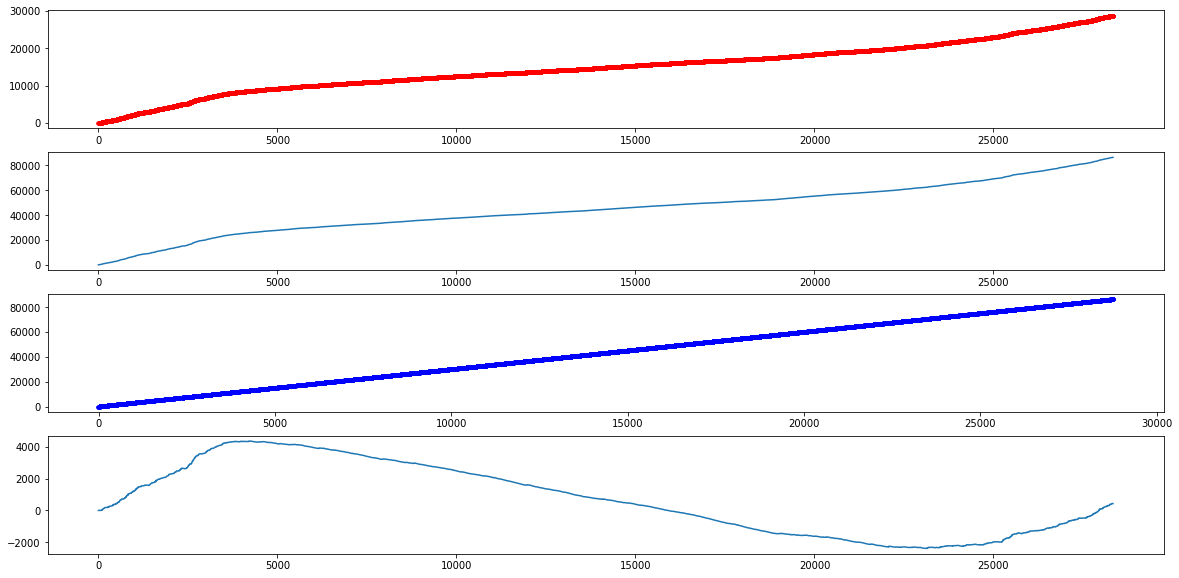

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(411)
ax.plot( predicted_indexes_moe_df.actual_index, predicted_indexes_moe_df.predicted_index,'r.');

ax = fig.add_subplot(412)
ax.plot(train_label[0] , train_data)

ax = fig.add_subplot(413)
ax.plot(predicted_indexes_moe_df.predicted_index , train_data, 'b.')

ax = fig.add_subplot(414)
ax.plot(train_label[0], error_in_index_moe)

In [213]:
predicted_indexes_moe_df.predicted_index.describe()

count    28338.000000
mean     14960.214844
std       6483.246094
min         -3.416920
25%      10722.918945
50%      14930.891113
75%      19346.112793
max      28890.855469
Name: predicted_index, dtype: float64

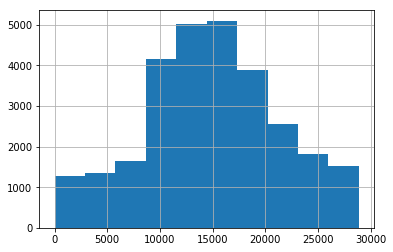

In [214]:
predicted_indexes_moe_df.predicted_index.hist()

In [215]:
predicted_indexes_moe_df.actual_index.describe()

count    28338.0000
mean     14168.5000
std       8180.6203
min          0.0000
25%       7084.2500
50%      14168.5000
75%      21252.7500
max      28337.0000
Name: actual_index, dtype: float64

#### Use the neural network index: ```trained_model``` to search for an index

In [236]:
def binarySearch(alist, item, predicted_index, max_abs_error):
    first = max(predicted_index - max_abs_error - 1,0)
    last = predicted_index + max_abs_error
    found = False
    midpoint = 0

    while first<=last and not found:
        midpoint = (first + last)//2
        if alist.iloc[midpoint,0] == item[0]:
            found = True
        else:
            if item[0] < alist.iloc[midpoint,0]:
                last = midpoint-1
            else:
                first = midpoint+1

    return found, midpoint

In [254]:
data=pd.concat([train_data,pd.Series(train_label[0])],axis=1)
data['predicted_index']=-1
data['found']=False
data['time_to_find']=0.0
data['found_at']=-1



In [263]:
import time
from tqdm import tqdm
max_abs_error = int(max(abs(error_in_index_moe)))
i=15

for i in tqdm(data.index):
    sample_timestamp_ps = train_data.iloc[i]
    strt = time.time()
    predicted_index = trained_model.predict(sample_timestamp_ps)[0]
    # print("predicted_index %s for timestamp (key) %s"%(predicted_index,sample_timestamp))
    # print(max_abs_error)
    found, index = binarySearch(data,sample_timestamp_ps,int(predicted_index),max_abs_error)
    end = time.time()
    data['predicted_index'].iloc[i]=predicted_index
    data['found'].iloc[i]=found
    data['time_to_find'].iloc[i]=end-strt
    data['found_at'].iloc[i]=index

#print("Found at %s"%index) if found else print("not found")


  1%|          | 325/28338 [06:16<11:09:11,  1.43s/it]

KeyboardInterrupt: 

In [267]:
#int(max(abs(error_in_index_moe)))
data[:300].describe()

,pk,0,time_to_find,found_at
count,300.000000,300.000000,300.000000,300.000000
mean,873.980000,149.500000,0.003785,149.493333
std,536.835089,86.746758,0.003901,86.801372
min,0.000000,0.000000,0.001794,1.000000
25%,331.750000,74.750000,0.002691,74.750000
50%,939.000000,149.500000,0.003039,149.500000
75%,1345.000000,224.250000,0.003596,225.000000
max,1718.000000,299.000000,0.055872,299.000000


In [63]:
pd.DataFrame(np.asarray(train_data)).describe()

,0
count,28338.000000
mean,44757.833510
std,19371.440366
min,0.000000
25%,32097.000000
50%,44670.000000
75%,57862.250000
max,86381.000000


In [89]:
from keras.models import load_model

trained_model.save('my_moe_web.h5')  # creates a HDF5 file 'my_model.h5'
trained_model.save_weights('my_moe_weights_web.h5')
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [118]:
!ls -ltrh


total 2032
-rw-r--r--@ 1 Sonai  staff   1.0K 22 Jan 07:07 LICENSE
-rw-r--r--@ 1 Sonai  staff   2.1K 22 Jan 07:07 README.md
drwxr-xr-x@ 4 Sonai  staff   128B 22 Jan 07:07 data
-rw-r--r--@ 1 Sonai  staff    81B 22 Jan 07:07 requirements.txt
-rw-r--r--@ 1 Sonai  staff    11K 24 Jan 07:49 mmoe.py
-rw-r--r--@ 1 Sonai  staff   8.6K 26 Jan 06:52 census_income_demo.py
-rw-r--r--@ 1 Sonai  staff   4.0K 26 Jan 07:28 synthetic_demo.py
-rw-r--r--@ 1 Sonai  staff   5.0K 26 Jan 07:32 weblog.py
-rw-r--r--@ 1 Sonai  staff   872B 27 Jan 07:14 kerasplt.py
-rw-r--r--@ 1 Sonai  staff   5.2K 28 Jan 19:07 web.py
drwxr-xr-x@ 5 Sonai  staff   160B 28 Jan 19:08 __pycache__
-rw-r--r--@ 1 Sonai  staff    51K 29 Jan 05:45 my_moe_web.h5
-rw-r--r--@ 1 Sonai  staff    25K 29 Jan 05:45 my_moe_weights_web.h5
-rw-r--r--@ 1 Sonai  staff   388K 29 Jan 06:29 my_btree_web.pickle
-rw-r--r--@ 1 Sonai  staff   145K 29 Jan 06:29 Untitled.ipynb
-rw-r--r--@ 1 Sonai  staff   332K 29 Jan 06:30 my_dict_web.pickle


Size of the persisted model weights is 25K. Whereas size of the persisted btree index is 388K. Moreover the size of the model weights will not grow with increase in number ofdata points.

In [88]:
!ls -lthr ../sdsc-http.txt

-rw-r--r--@ 1 Sonai  staff   3.4M 12 Jan 19:51 ../sdsc-http.txt


In [310]:
n_df = pd.DataFrame(index=train_data['pk'].values, data=train_data['pk'].index)
n_df.to_dict()[0]


{0.0: 1,
 5.0: 2,
 9.0: 3,
 16.0: 4,
 20.0: 5,
 22.0: 9,
 28.0: 11,
 33.0: 12,
 46.0: 13,
 54.0: 14,
 56.0: 15,
 58.0: 16,
 59.0: 17,
 61.0: 18,
 63.0: 19,
 64.0: 21,
 75.0: 22,
 77.0: 23,
 81.0: 24,
 82.0: 25,
 109.0: 26,
 110.0: 27,
 115.0: 28,
 125.0: 29,
 156.0: 30,
 160.0: 31,
 166.0: 33,
 179.0: 34,
 181.0: 36,
 190.0: 37,
 196.0: 38,
 198.0: 39,
 199.0: 40,
 200.0: 41,
 205.0: 42,
 207.0: 43,
 217.0: 44,
 219.0: 45,
 223.0: 46,
 232.0: 47,
 233.0: 48,
 239.0: 49,
 241.0: 50,
 245.0: 51,
 247.0: 53,
 249.0: 54,
 252.0: 55,
 253.0: 56,
 254.0: 57,
 258.0: 58,
 261.0: 59,
 269.0: 60,
 274.0: 61,
 280.0: 63,
 281.0: 65,
 286.0: 66,
 307.0: 68,
 309.0: 69,
 310.0: 70,
 313.0: 71,
 316.0: 72,
 318.0: 73,
 328.0: 74,
 333.0: 75,
 337.0: 76,
 341.0: 77,
 343.0: 78,
 344.0: 79,
 345.0: 80,
 347.0: 81,
 349.0: 82,
 355.0: 84,
 375.0: 86,
 377.0: 87,
 379.0: 88,
 382.0: 89,
 386.0: 90,
 390.0: 91,
 434.0: 93,
 485.0: 94,
 506.0: 95,
 507.0: 96,
 521.0: 99,
 522.0: 102,
 524.0: 103,
 533.0:

In [311]:
from BTrees.OOBTree import OOBTree
t = OOBTree()
t.update(n_df.to_dict()[0])

In [276]:
import pickle,sys
sys.setrecursionlimit(30000)
with open('my_btree_web.pickle', 'wb+') as f:
    pickle.dump(t,f)

In [277]:
import pickle,sys
sys.setrecursionlimit(30000)
with open('my_dict_web.pickle', 'wb+') as f:
    pickle.dump(train_data.to_dict()['pk'],f)

In [299]:
import BTrees.check
BTrees.check.display(t)

 OOBTree (0xb3a0dd9d8 oid=None) with 1 children
    0 OOBucket (0xb3a15e0c8 oid=None) with 1 keys
        key 0: 0
value 0.0            0
0.0            1
5.0            2
9.0            3
16.0           4
20.0           5
22.0           6
22.0           7
22.0           8
22.0           9
28.0          10
28.0          11
33.0          12
46.0          13
54.0          14
56.0          15
58.0          16
59.0          17
61.0          18
63.0          19
64.0          20
64.0          21
75.0          22
77.0          23
81.0          24
82.0          25
109.0         26
110.0         27
115.0         28
125.0         29
           ...  
86278.0    28308
86283.0    28309
86297.0    28310
86301.0    28311
86305.0    28312
86309.0    28313
86309.0    28314
86310.0    28315
86311.0    28316
86314.0    28317
86316.0    28318
86318.0    28319
86327.0    28320
86335.0    28321
86337.0    28322
86338.0    28323
86338.0    28324
86338.0    28325
86340.0    28326
86342.0    28327
86346.0    2

In [294]:
type(t)

BTrees.OOBTree.OOBTree

In [316]:
import time
from tqdm import tqdm
n_df['found']=False
n_df['time_to_find']=0.0
n_df['found_at']=-1
max_abs_error = int(max(abs(error_in_index_moe)))
i=15

for i in tqdm(n_df.index):
    strt=time.time()
    found_at=t.get(i)
    end=time.time()
    n_df['found'].loc[i]=True# if found_at else False
    n_df['found_at'].loc[i]=found_at
    n_df['time_to_find'].loc[i]=end-strt



  0%|          | 0/28338 [00:00<?, ?it/s]/Users/shreyadutta/conda/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


  0%|          | 1/28338 [00:01<8:09:12,  1.04s/it]

  0%|          | 2/28338 [00:02<8:22:22,  1.06s/it]

  0%|          | 3/28338 [00:03<8:05:39,  1.03s/it]

  0%|          | 4/28338 [00:04<8:23:57,  1.07s/it]

  0%|          | 5/28338 [00:05<8:09:22,  1.04s/it]

  0%|          | 6/28338 [00:06<7:59:51,  1.02s/it]

  0%|          | 7/28338 [00:07<7:48:42,  1.01it/s]

  0%|          | 8/28338 [00:08<7:40:10,  1.03it/s]

  0%|          | 9/28338 [00:09<7:40:03,  1.03it/s]

  0%|          | 10/28338 [00:09<7:36:04,  1.04it/s]

  0%|          | 11/28338 [00:10<7:36:46,  1.03it/s]

  0%|    

KeyboardInterrupt: 

In [326]:
n_df.iloc[:300].describe()

,0,time_to_find,found_at
count,300.000000,300.000000,300.000000
mean,149.500000,0.000008,149.753333
std,86.746758,0.000003,86.803699
min,0.000000,0.000006,1.000000
25%,74.750000,0.000007,74.750000
50%,149.500000,0.000008,151.000000
75%,224.250000,0.000009,226.000000
max,299.000000,0.000025,299.000000


In [288]:
train_data['pk'].index

RangeIndex(start=0, stop=28338, step=1)

In [292]:
n_df

,0
0.0,0
0.0,1
5.0,2
9.0,3
16.0,4
20.0,5
22.0,6
22.0,7
22.0,8
22.0,9
